# First Notebook : basic algorithms

## Importing necessary packages

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
%matplotlib inline

## Detection rectangles on edges 
https://pythontips.com/2015/03/11/a-guide-to-finding-books-in-images-using-python-and-opencv/

In [2]:
# load the first image in the folder ../images/, converts it to grayscale
imagePath = '../images/' + os.listdir('../images/')[0]
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [3]:
cv2.imshow('Gray',gray)
cv2.waitKey()

-1

In [4]:
# Detects edges in the image
edged = cv2.Canny(gray, 10, 250)
cv2.imshow("Edged", edged)
cv2.waitKey(0)

-1

In [5]:
# construct and apply a closing kernel to 'close' gaps between 'white' pixels
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
cv2.imshow("Closed", closed)
cv2.waitKey(0)

-1

In [6]:
# find contours (i.e. the 'outlines') in the image and initialize the
# total number of rectangles found
(_,cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
total = 0

In [7]:
imageRectangleContours = image.copy()
# loop over the contours
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0, True)

    # if the approximated contour has four points, then assume that the
    # contour is a rectangle
    if len(approx) == 4:
        cv2.drawContours(imageRectangleContours, [approx], -1, (0, 255, 0), 4)
        total += 1

In [8]:
# display the output
print("I found {0} rectangles in that image".format(total))
cv2.imshow("Output", imageRectangleContours)
cv2.waitKey(0)

I found 125 rectangles in that image


-1

## Histogram of Gradients

In [9]:
from skimage.feature import hog
from skimage import data, color, exposure

In [10]:
fd, hog_image = hog(gray/255, orientations=8, pixels_per_cell=(7, 7),
                    cells_per_block=(1, 1), visualise=True)

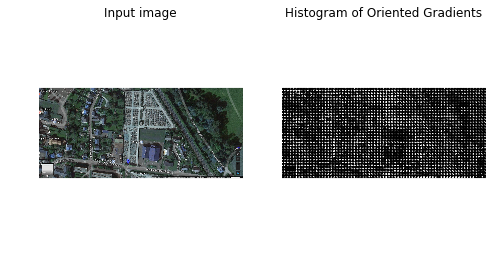

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box-forced')
plt.show()

In [12]:
cv2.imshow('HOG',hog_image_rescaled)
cv2.waitKey(0)

-1

## Corner detection

In [13]:
from skimage import data
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, AffineTransform
from skimage.draw import ellipse

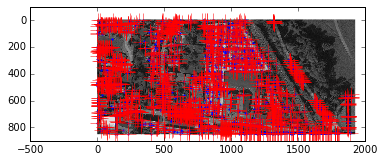

In [14]:
imageCorner = gray/255

coords = corner_peaks(corner_harris(imageCorner, 1), min_distance=1)
coords_subpix = corner_subpix(imageCorner, coords, window_size=13)

fig, ax = plt.subplots()
ax.imshow(imageCorner, interpolation='nearest', cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], '.b', markersize=3)
ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
plt.show()

## Segmentation

In [15]:
from skimage.segmentation import felzenszwalb, slic, quickshift
from skimage.segmentation import mark_boundaries

Felzenszwalb number of segments: 3
SLIC number of segments: 180
Quickshift number of segments: 6715


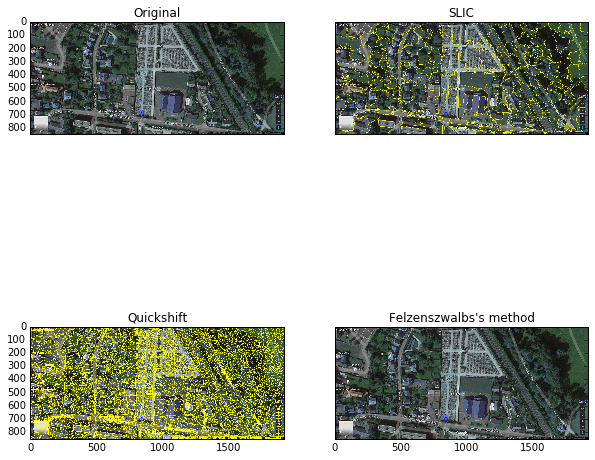

In [16]:
segments_fz = felzenszwalb(image, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(image, n_segments=250, compactness=10, sigma=1)
segments_quick = quickshift(image, kernel_size=3, max_dist=6, ratio=0.5)

print("Felzenszwalb number of segments: {}".format(len(np.unique(segments_fz))))
print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))
print('Quickshift number of segments: {}'.format(len(np.unique(segments_quick))))

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True,
                       subplot_kw={'adjustable': 'box-forced'})

ax[0, 0].imshow(image)
ax[0, 0].set_title('Original')
ax[0, 1].imshow(mark_boundaries(image, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(image, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(image, segments_fz))
ax[1, 1].set_title("Felzenszwalbs's method")

## Hough transform

In [17]:
hogThresh = (hog_image>0.01)*255
hogThresh = hogThresh.astype(np.uint8)

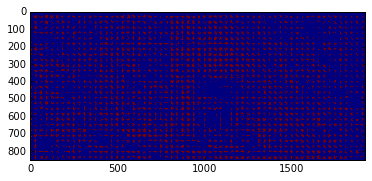

In [18]:
plt.imshow(hogThresh)

In [19]:
lines = cv2.HoughLines(hogThresh,1,np.pi/180,500)

In [20]:
imageHough = image.copy()
for line in lines:
    for rho,theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(imageHough,(x1,y1),(x2,y2),(0,0,255),2)

In [21]:
cv2.imshow('iii',imageHough)
cv2.waitKey(0)

-1

## Histogram Equalization

In [22]:
imageEqualized = np.dstack((cv2.equalizeHist(image[:,:,0]),cv2.equalizeHist(image[:,:,1]), cv2.equalizeHist(image[:,:,2])))

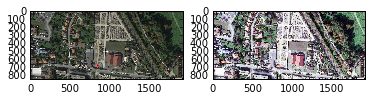

In [23]:
fig, ax = plt.subplots(nrows=1,ncols=2)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(imageEqualized, cv2.COLOR_BGR2RGB))

# ORB (Free version of SIFT)

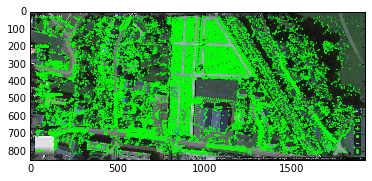

(<matplotlib.image.AxesImage at 0x8941898>, None)

In [24]:
orb = cv2.ORB_create(nfeatures=100000)
kp = orb.detect(image,None)
kp, des = orb.compute(image, kp)
image2=image.copy()
image2 = cv2.drawKeypoints(image2,kp,image2,color=(0,255,0), flags=0)
plt.imshow(image2),plt.show()


In [25]:
cv2.imshow('iii',image2)
cv2.waitKey(0)

-1

### Motivation : 
- cemetery is where there is a big concentration of ORB descriptors
- in cemetery descriptors are aligned on grid

In [26]:
#Making image with just feature points
matrixKp = np.zeros((len(kp),2))
for i in range(len(kp)):
    matrixKp[i,0], matrixKp[i,1] = kp[i].pt

In [27]:
imageKp = np.zeros(image.shape)
for i in range(len(kp)):
    imageKp[int(matrixKp[i,1]),int(matrixKp[i,0])]=255

In [28]:
cv2.imshow('Keypoints',imageKp)
cv2.waitKey(0)

-1

In [29]:
#Blurring the image
imageKpBlurred = cv2.GaussianBlur(imageKp,(0,0),1)

In [30]:
cv2.imshow('Keypoints blurred',imageKpBlurred)
cv2.waitKey(0)

-1